### IMPORTS

In [97]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import math
import tqdm
import tensorflow as tf
import pickle
import json
import requests
import urllib.request
import pytz
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import datetime 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import BertTokenizer, TFBertModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from scipy.stats import uniform
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from numpy import array, vstack
from sklearn.model_selection import train_test_split

# GETTING THE DATA

### STOCK PRICE DATA

In [ ]:
#APIkey = Api key issued by polygon.io, free and paid versions available
APIkey='[API key]'

#request data - one day, 30 min bars, ohlc - 13 rows
def getPolygonData(after, ticker):
    min30 = 1800000
    timeFrame = 14*min30
    def fire_away(after=after):
        before = int(after)+timeFrame
        before = str(before)
        url = 'https://api.polygon.io/v2/aggs/ticker/{ticker}/range/30/minute/{after}/{before}?unadjusted=false&apiKey={APIkey}'.format(ticker=ticker, after=after, before=before, APIkey=APIkey)
        print(url)
        response = requests.get(url)
        assert response.status_code == 200
        data = json.loads(response.text)
        return data
    current_tries = 1
    while current_tries < 6:
        try:
            time.sleep(.2)
            response = fire_away()
            return response
        except:
            time.sleep(.2)
            current_tries += 1
    return fire_away()

#loop through and record 13 lines of data for each day in given time period
def recordData(after, last, ticker):
    start_time = time.time()
    count = 0
    opn, high, low, close, volume, epochDate = [], [], [], [], [], []
    df = pd.DataFrame()
    min30 = 1800000
    oneDay = 86400000
    while int(after) < int(last):
        #account for daylight savings
        if after in ('1667827800000','1636378200000','1604323800000', '1572874200000',
                     '1541424600000', '1509975000000', '1478525400000', '1446471000000',
                     '1415021400000'):
            after = str(int(after)+(2*min30))
            print('added one hour')
        if after in ('1647181800000','1615732200000','1583677800000', '1552314600000',
                     '1520778600000', '1489329000000', '1457879400000', '1425825000000',
                     '1394375400000'):
            after = str(int(after)-(2*min30))
            print('subtracted one hour')
        tries = 0
        while tries < 2:
            data = getPolygonData(after=after, ticker=ticker)
            #ensure it is a full day of trading (no weekends, half days, or holidays)
            if data['resultsCount'] < 13:    
                tries += 1
                time.sleep(10)
            else:
                z = 0
                length = 13
                #record data
                while z < length:
                    opn.append(data['results'][z]['o'])
                    high.append(data['results'][z]['h'])
                    low.append(data['results'][z]['l'])
                    close.append(data['results'][z]['c'])
                    volume.append(data['results'][z]['v'])
                    epochDate.append(data['results'][z]['t'])
                    z+=1
                break
        count
        count+=1
        print(count)    
        after = int(after)
        after+=oneDay
        after = str(after)
        time.sleep(12) 
    #copy to dataframe    
    df['opn'] = opn
    df['high'] = high
    df['low'] = low
    df['close'] = close
    df['volume'] = volume
    df['epochDate'] = epochDate
    df['date'] = pd.to_datetime(df['epochDate'], unit='ms').dt.tz_localize('utc').dt.tz_convert('America/Los_Angeles')    
    end_time = time.time()
    totalTime = (end_time-start_time)/60
    
    #df.to_csv('30Min'+str(ticker)+'2yrs.csv')
    return df, totalTime


df, totalTime = recordData('[starting_epoch_in_ms]', '[ending_epoch_in_ms]', '[stock_ticker]') 
 

In [26]:
#import stock price dfs and parse dates
def importFunc(path):
    dfName = pd.read_csv(str(path), index_col=(0))
    for j in range(len(dfName)):
        dfName.loc[j,'date'] = parse(dfName['date'][j])
    return dfName

dfamzn = importFunc('data/30MinAMZN2yrs.csv')
dfaapl = importFunc('data/30MinAAPL2yrs.csv')
dfgoog = importFunc('data/30MinGOOG2yrs.csv')

### TEXT DATA

In [ ]:
#format request
def newsFilterPull(frm, ticker, company, begin, end):
    # API key
    API_KEY = 'API_KEY'

    # Define the filter parameters
    queryString = "(title:{company} OR title:{ticker}) AND publishedAt:[{begin} TO {end}]".format(company=company,ticker=ticker,begin=begin,end=end)
    payload = {
        "type": "filterArticles",
        "queryString": queryString,
        "from": frm,
        "size": 50
        }
    
    #establish and send request
    jsondata = json.dumps(payload)
    jsondataasbytes = jsondata.encode('utf-8')
    
    API_ENDPOINT = "https://api.newsfilter.io/public/actions?token={}".format(API_KEY)
    req = urllib.request.Request(API_ENDPOINT)

    req.add_header('Content-Type', 'application/json; charset=utf-8')
    req.add_header('Content-Length', len(jsondataasbytes))

    response = urllib.request.urlopen(req, jsondataasbytes)
    res_body = response.read()

    articles = json.loads(res_body.decode("utf-8"))
    return articles

#looping and recording function
def createDateframe(frm, ticker, company, begin, end):
    start_time = time.time()
    date = []
    title = []
    desc = []
    source = []

    #create looping function
    def loopingFunc(frm, ticker, company, begin, end):
        y = frm + 1
        #loop through articles pulling and recording 50 at a time
        while frm < y:
            time.sleep(2)
            print('running - slowly but surely : ', frm)
            articles = newsFilterPull(frm=frm, ticker=ticker, company=company, begin=begin, end=end)
            l = 0
            #record title, date, source, and description if it exists
            while l < len(articles['articles']):
                title.append(articles['articles'][l]['title'])
                date.append(articles['articles'][l]['publishedAt'])
                source.append(articles['articles'][l]['source']['name'])
                try:
                    desc.append(articles['articles'][l]['description'])
                except:
                    desc.append('')
                l+=1
            y = articles['total']['value']
            frm += 50
            #when at the end and if total exeeds 10,000 restart request with updated parameters
            if (frm >= y) and (articles['total']['relation'] == 'gte'):
                timestampStr = parse(date[-1]).strftime("%Y-%m-%d")
                loopingFunc(frm=0, ticker=ticker, company=company, begin=begin, end=timestampStr)
            
    #run looping func
    loopingFunc(frm=frm,ticker=ticker,company=company,begin=begin,end=end)
       
    #create dataframe and copy lists to dataframe
    df = pd.DataFrame()        
    df['date'] = date
    df['title'] = title
    df['description'] = desc
    df['source'] = source
    
    #convert dates to same timezone
    for j in range(len(df)):
        df['date'][j] = parse(df['date'][j]).astimezone(pytz.timezone('America/Los_Angeles'))
     
    end_time = time.time()
    totalTime = (end_time-start_time)/60
    #df.to_csv('news'+str(ticker)+'2yrs.csv')
    return df, totalTime
    
    
df, totalTime = createDateframe(frm=0, ticker='GS', company='Goldman Sachs', begin='2019-03-08', end='2021-03-13')


In [6]:
#import and prepare news df 
def prepNews(ticker):
    df = pd.read_csv('data/news'+str(ticker)+'2yrs.csv', index_col=(0))
    for j in range(len(df)):
        df['date'][j] = parse(df['date'][j])
    df = df.drop_duplicates(subset='title', keep='last')
    df = df[df.source != 'SEC']
    df['description'] = df['description'].replace(np.nan, '')
    return df.reset_index(drop=True)

dfamznNews = prepNews('AMZN')
dfaaplNews = prepNews('AAPL')
dfgoogNews = prepNews('GOOG')

# BUILD SENTIMENT ANALYSIS MODEL FOR TEXT DATA

#### ENGINEER NEW AND USEFUL FEATURES FROM FINANCIAL NEWS DATA

Import data and split into train/test

In [104]:
df = pd.read_csv("data\FinancialPhraseBank\Sentences_AllAgree.txt", sep='@', header=None)
df['pos'] = 0
df['neg'] = 0
df['neut'] = 0

df.loc[(df[1] == 'positive'), 'pos'] = 1
df.loc[(df[1] == 'negative'), 'neg'] = 1
df.loc[(df[1] == 'neutral'), 'neut'] = 1
df['sentence'] = df[0]

#shuffle and Train/Test split data
df = df.sample(frac=1)
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df[['pos','neg','neut']], test_size=0.20, random_state=42)


In [101]:
#evaluation funcs
def evalModel(yTrue, yPred):
    print(confusion_matrix(yTrue,yPred))
    print("Accuracy:", accuracy_score(yTrue,yPred))
    print("F1:", f1_score(yTrue,yPred, average='weighted'))
    print("Precision:", precision_score(yTrue,yPred, average='weighted'))
    print("Recall:", recall_score(yTrue,yPred, average='weighted'))   

def plotLoss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('tain loss vs val loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def plotAcc():
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('train acc vs val acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    

#plotLoss()
#plotAcc()
#evalModel()

### Simple text embedding

In [105]:
#fit tokenizer on text
t = Tokenizer()
t.fit_on_texts(X_train)

#look at tokenizer info
z=t.word_counts
z=t.word_index
z=t.word_docs

#tokenize, truncate, and pad text
encodedText = t.texts_to_sequences(X_train)
max_length = 100
pad_trunc_Text = pad_sequences(encodedText, maxlen=max_length, padding='post', truncating='post')
vocab_size = len(t.word_index)+1

Epoch 1/100
46/46 [==============================] - 1s 10ms/step - loss: 1.1760 - accuracy: 0.2776 - val_loss: 1.0979 - val_accuracy: 0.3085
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 1.1520 - accuracy: 0.3047 - val_loss: 1.0968 - val_accuracy: 0.4187
Epoch 3/100
46/46 [==============================] - 0s 5ms/step - loss: 1.1137 - accuracy: 0.3582 - val_loss: 1.0968 - val_accuracy: 0.3857
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 1.0934 - accuracy: 0.3964 - val_loss: 1.0972 - val_accuracy: 0.3829
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 1.0975 - accuracy: 0.3784 - val_loss: 1.0964 - val_accuracy: 0.4022
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 1.0946 - accuracy: 0.3965 - val_loss: 1.0969 - val_accuracy: 0.3939
Epoch 7/100
46/46 [==============================] - 0s 5ms/step - loss: 1.0875 - accuracy: 0.3770 - val_loss: 1.0975 - val_accuracy: 0.3912
Epoch 8/100


Epoch 59/100
46/46 [==============================] - 0s 5ms/step - loss: 0.9877 - accuracy: 0.5498 - val_loss: 1.0695 - val_accuracy: 0.4931
Epoch 60/100
46/46 [==============================] - 0s 5ms/step - loss: 0.9919 - accuracy: 0.5484 - val_loss: 1.0698 - val_accuracy: 0.4931
Epoch 61/100
46/46 [==============================] - 0s 5ms/step - loss: 0.9823 - accuracy: 0.5596 - val_loss: 1.0642 - val_accuracy: 0.5124
Epoch 62/100
46/46 [==============================] - 0s 5ms/step - loss: 0.9769 - accuracy: 0.5564 - val_loss: 1.0742 - val_accuracy: 0.4711
Epoch 63/100
46/46 [==============================] - 0s 5ms/step - loss: 0.9812 - accuracy: 0.5669 - val_loss: 1.0660 - val_accuracy: 0.5069
Epoch 64/100
46/46 [==============================] - 0s 5ms/step - loss: 0.9749 - accuracy: 0.5791 - val_loss: 1.0704 - val_accuracy: 0.4848
Epoch 65/100
46/46 [==============================] - 0s 5ms/step - loss: 0.9748 - accuracy: 0.5711 - val_loss: 1.0618 - val_accuracy: 0.5262
Epoch 

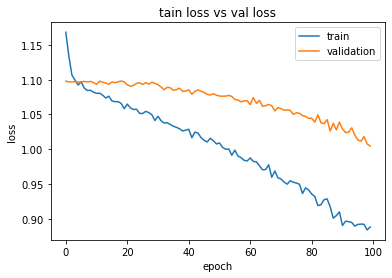

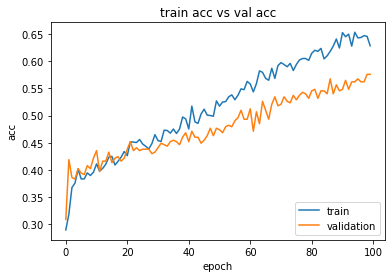

[[ 56  26  28]
 [ 35  16   9]
 [ 55  24 204]]
Accuracy: 0.609271523178808
F1: 0.6263007511617289
Precision: 0.654059829111014
Recall: 0.609271523178808


In [109]:
#other methods -
'''
#tfidf, count, etc methods with tokenizer (non-learning word vectorization)
encoded_matrix = t.texts_to_matrix(X_train, mode='tfidf')

#using one_hot func instead of tokenizer
vocab_size = 30000
OneHot = [one_hot(d, vocab_size) for d in X_train]
max_length = 200
pad_OneHot = pad_sequences(OneHot, maxlen=max_length, padding='post', truncating='post')
'''

#build embedding model using functional API
inputs = tf.keras.Input(shape=(max_length,))
x = tf.keras.layers.Embedding(vocab_size, 50, mask_zero=True)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dropout(.4)(x)
x = tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.Dense(3, activation="softmax")(x)

#build embedding model using sequential API
'''
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dropout(.4))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
'''

#choose optimizer
opt = Adam(7e-6)
#opt = SGD(lr=1e-4, momentum=0.0,nesterov=True)

#compile and fit model
model = tf.keras.Model(inputs=inputs, outputs=out)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(pad_trunc_Text,y_train,epochs=100,batch_size=32,validation_split=0.2,callbacks=early_stop,shuffle=True)
model.summary()

encodedTextTest = t.texts_to_sequences(X_test)
pad_trunc_TextTest = pad_sequences(encodedTextTest, maxlen=max_length, padding='post', truncating='post')
u = model.predict(pad_trunc_TextTest)
yPred = np.argmax(u, axis=1)
w = np.asarray(y_test)
yTrue = np.argmax(w, axis=1)

plotLoss()
plotAcc()
evalModel(yTrue, yPred)

### GloVe with dense layers

In [110]:
#fit tokenizer on text
t = Tokenizer()
t.fit_on_texts(X_train)

#look at tokenizer info
z=t.word_counts
z=t.word_index
z=t.word_docs

In [112]:
#tokenize, truncate, and pad text
encodedText = t.texts_to_sequences(X_train)
max_length = 100
pad_trunc_Text = pad_sequences(encodedText, maxlen=max_length, padding='post', truncating='post')
vocab_size = len(t.word_index)+1

#load GloVe embeddings
embeddings_index = dict()
f = open('data/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('word vectors = {}'.format(len(embeddings_index)))

#create a weight matrix with training data for embedding layer
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

word vectors = 400000


Epoch 1/100
46/46 [==============================] - 1s 14ms/step - loss: 1.4009 - accuracy: 0.2697 - val_loss: 1.0975 - val_accuracy: 0.3251
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: 1.3533 - accuracy: 0.2861 - val_loss: 1.1018 - val_accuracy: 0.3471
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 1.2899 - accuracy: 0.3013 - val_loss: 1.1043 - val_accuracy: 0.3444
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 1.2926 - accuracy: 0.3121 - val_loss: 1.1020 - val_accuracy: 0.3829
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 1.2251 - accuracy: 0.3641 - val_loss: 1.0964 - val_accuracy: 0.4022
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: 1.2055 - accuracy: 0.3602 - val_loss: 1.0944 - val_accuracy: 0.4270
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: 1.2233 - accuracy: 0.3577 - val_loss: 1.0896 - val_accuracy: 0.4435
Epoch 8/100


Epoch 59/100
46/46 [==============================] - 0s 7ms/step - loss: 0.7744 - accuracy: 0.5896 - val_loss: 0.9521 - val_accuracy: 0.6309
Epoch 60/100
46/46 [==============================] - 0s 7ms/step - loss: 0.7596 - accuracy: 0.6081 - val_loss: 0.9444 - val_accuracy: 0.6336
Epoch 61/100
46/46 [==============================] - 0s 8ms/step - loss: 0.7403 - accuracy: 0.6258 - val_loss: 0.9409 - val_accuracy: 0.6309
Epoch 62/100
46/46 [==============================] - 0s 7ms/step - loss: 0.7395 - accuracy: 0.6233 - val_loss: 0.9421 - val_accuracy: 0.6226
Epoch 63/100
46/46 [==============================] - 0s 7ms/step - loss: 0.7288 - accuracy: 0.6342 - val_loss: 0.9443 - val_accuracy: 0.6198
Epoch 64/100
46/46 [==============================] - 0s 8ms/step - loss: 0.7185 - accuracy: 0.6452 - val_loss: 0.9406 - val_accuracy: 0.6226
Epoch 65/100
46/46 [==============================] - 0s 7ms/step - loss: 0.7249 - accuracy: 0.6474 - val_loss: 0.9368 - val_accuracy: 0.6226
Epoch 

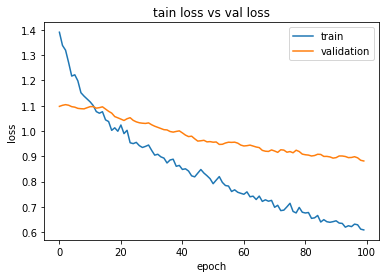

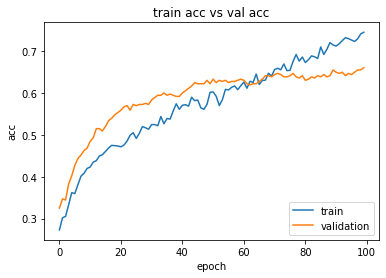

[[ 60  30  20]
 [ 23  32   5]
 [ 25  14 244]]
Accuracy: 0.7417218543046358
F1: 0.748287325894801
Precision: 0.7573358802741993
Recall: 0.7417218543046358


In [114]:
#build model using GloVe embeddings and freeze embedding layer intially 
inputs = tf.keras.Input(shape=(max_length,))
x = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=200, trainable=False, mask_zero=True)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dropout(.4)(x)
x = tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.Dense(3, activation="softmax")(x)


#choose optimizer
opt = Adam(2e-5)
#opt = SGD(lr=1e-4, momentum=0.0,nesterov=True)

#compile and train model with embedding layer frozen
model = tf.keras.Model(inputs=inputs, outputs=out)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(pad_trunc_Text,y_train,epochs=100,batch_size=32,validation_split=0.2,callbacks=early_stop,shuffle=True)
model.summary()

encodedTextTest = t.texts_to_sequences(X_test)
pad_trunc_TextTest = pad_sequences(encodedTextTest, maxlen=max_length, padding='post', truncating='post')
u = model.predict(pad_trunc_TextTest)
yPred = np.argmax(u, axis=1)
w = np.asarray(y_test)
yTrue = np.argmax(w, axis=1)

plotLoss()
plotAcc()
evalModel(yTrue, yPred)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001CD1B5D13D0> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CD1B5D10D0> False
<tensorflow.python.keras.layers.core.Flatten object at 0x000001CD63535E50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001CD21201310> True
<tensorflow.python.keras.layers.core.Dense object at 0x000001CD1B5D9DC0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x000001CD1B5D9FD0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000001CD1B5F27F0> True
<tensorflow.python.keras.layers.core.Dense object at 0x000001CD1B5F2B80> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001CD1B5D13D0> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CD1B5D10D0> True
<tensorflow.python.keras.layers.core.Flatten object at 0x000001CD63535E50> True
<tensorflow.python.keras.layers.normaliza

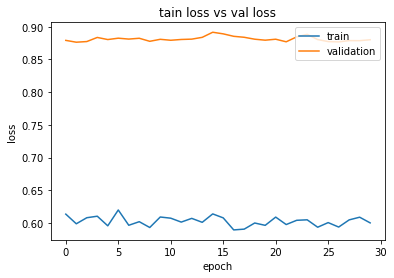

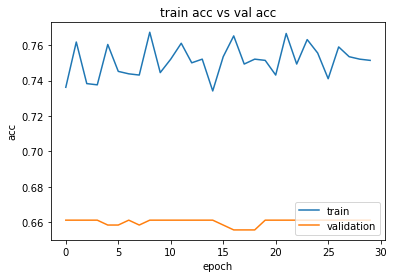

[[ 59  31  20]
 [ 23  32   5]
 [ 25  14 244]]
Accuracy: 0.739514348785872
F1: 0.7462103114352283
Precision: 0.7556029918342293
Recall: 0.739514348785872


In [115]:
#unfreeze embedding layer
for layer in model.layers[:]:
    print(layer, layer.trainable)

for layer in model.layers[1:2]:
    layer.trainable = True

for layer in model.layers[:]:
    print(layer, layer.trainable)

#decrease learning rate, compile, and train model again for a few more epochs
opt = Adam(2e-7)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
history = model.fit(pad_trunc_Text,y_train,epochs=30,batch_size=32,validation_split=0.2,shuffle=True)
model.summary()

encodedTextTest = t.texts_to_sequences(X_test)
pad_trunc_TextTest = pad_sequences(encodedTextTest, maxlen=max_length, padding='post', truncating='post')
u = model.predict(pad_trunc_TextTest)
yPred = np.argmax(u, axis=1)
w = np.asarray(y_test)
yTrue = np.argmax(w, axis=1)

plotLoss()
plotAcc()
evalModel(yTrue, yPred)

### GloVe with LSTM layers

Epoch 1/100
46/46 [==============================] - 15s 125ms/step - loss: 1.1909 - accuracy: 0.2740 - val_loss: 1.1579 - val_accuracy: 0.1653
Epoch 2/100
46/46 [==============================] - 3s 64ms/step - loss: 1.1632 - accuracy: 0.2774 - val_loss: 1.1465 - val_accuracy: 0.1708
Epoch 3/100
46/46 [==============================] - 3s 69ms/step - loss: 1.1517 - accuracy: 0.2864 - val_loss: 1.1352 - val_accuracy: 0.1818
Epoch 4/100
46/46 [==============================] - 3s 72ms/step - loss: 1.1360 - accuracy: 0.3207 - val_loss: 1.1236 - val_accuracy: 0.1956
Epoch 5/100
46/46 [==============================] - 3s 75ms/step - loss: 1.1236 - accuracy: 0.3226 - val_loss: 1.1118 - val_accuracy: 0.2204
Epoch 6/100
46/46 [==============================] - 3s 69ms/step - loss: 1.1130 - accuracy: 0.3309 - val_loss: 1.0998 - val_accuracy: 0.2865
Epoch 7/100
46/46 [==============================] - 3s 64ms/step - loss: 1.0953 - accuracy: 0.3757 - val_loss: 1.0880 - val_accuracy: 0.3526
Epoc

46/46 [==============================] - 3s 65ms/step - loss: 0.8098 - accuracy: 0.7067 - val_loss: 0.7841 - val_accuracy: 0.6942
Epoch 59/100
46/46 [==============================] - 3s 62ms/step - loss: 0.7962 - accuracy: 0.7018 - val_loss: 0.7808 - val_accuracy: 0.6942
Epoch 60/100
46/46 [==============================] - 3s 62ms/step - loss: 0.7887 - accuracy: 0.6895 - val_loss: 0.7773 - val_accuracy: 0.6997
Epoch 61/100
46/46 [==============================] - 3s 62ms/step - loss: 0.7751 - accuracy: 0.7319 - val_loss: 0.7740 - val_accuracy: 0.6997
Epoch 62/100
46/46 [==============================] - 3s 65ms/step - loss: 0.7947 - accuracy: 0.7065 - val_loss: 0.7705 - val_accuracy: 0.6970
Epoch 63/100
46/46 [==============================] - 3s 62ms/step - loss: 0.7834 - accuracy: 0.7226 - val_loss: 0.7679 - val_accuracy: 0.6970
Epoch 64/100
46/46 [==============================] - 3s 62ms/step - loss: 0.7954 - accuracy: 0.7114 - val_loss: 0.7648 - val_accuracy: 0.6997
Epoch 65/100

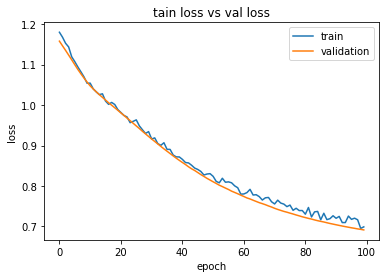

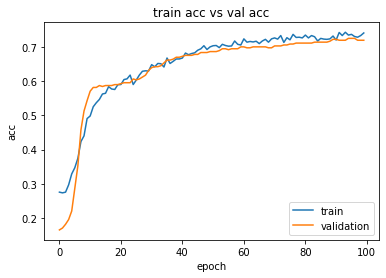

[[ 70   0  40]
 [ 46   0  14]
 [ 17   0 266]]
Accuracy: 0.7417218543046358
F1: 0.6910656973221267
Precision: 0.647104827466016
Recall: 0.7417218543046358


C:\Users\Jonathan\anaconda3\envs\NewDeep\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
#build model using GloVe embeddings and LSTM layers
inputs = tf.keras.Input(shape=(max_length,))
x = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=200, trainable=False, mask_zero=True)(inputs)
x = tf.keras.layers.LSTM(10, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.LSTM(10)(x)
x = tf.keras.layers.Dropout(0.4)(x)
out = tf.keras.layers.Dense(3, activation="softmax")(x)

#choose optimizer
opt = Adam(2e-5)

#reshape for LSTM
pad_trunc_Text22 = pad_trunc_Text.reshape((1811,100,1))

model = tf.keras.Model(inputs=inputs, outputs=out)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(pad_trunc_Text22,y_train,epochs=100,batch_size=32,validation_split=0.2,callbacks=early_stop,shuffle=True)
model.summary()

encodedTextTest = t.texts_to_sequences(X_test)
pad_trunc_TextTest = pad_sequences(encodedTextTest, maxlen=max_length, padding='post', truncating='post')
u = model.predict(pad_trunc_TextTest)
yPred = np.argmax(u, axis=1)
w = np.asarray(y_test)
yTrue = np.argmax(w, axis=1)

plotLoss()
plotAcc()
evalModel(yTrue, yPred)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001CD11826D30> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CD11826DC0> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001CD206F8AC0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x000001CD11B54040> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001CD5ECD8CA0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x000001CD04849820> True
<tensorflow.python.keras.layers.core.Dense object at 0x000001CD074FC730> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001CD11826D30> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CD11826DC0> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001CD206F8AC0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x000001CD11B54040> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001CD

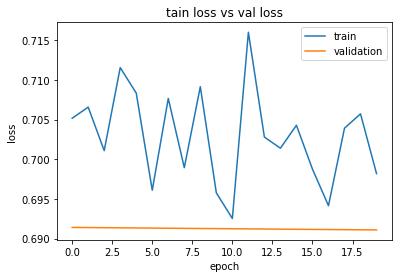

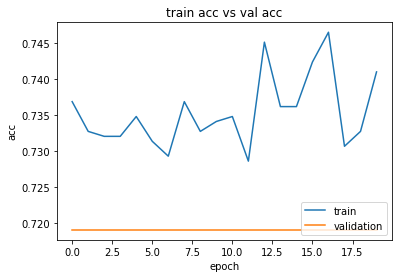

[[ 70   0  40]
 [ 46   0  14]
 [ 17   0 266]]
Accuracy: 0.7417218543046358
F1: 0.6910656973221267
Precision: 0.647104827466016
Recall: 0.7417218543046358


C:\Users\Jonathan\anaconda3\envs\NewDeep\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: y_true takes value in {0, 2} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [117]:
#unfreeze embedding layer
for layer in model.layers[:]:
    print(layer, layer.trainable)

for layer in model.layers[1:2]:
    layer.trainable = True

for layer in model.layers[:]:
    print(layer, layer.trainable)

#decrease learning rate, compile, and train model again for a few more epochs
opt = Adam(2e-7)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(pad_trunc_Text,y_train,epochs=20,batch_size=32,validation_split=0.2,callbacks=early_stop,shuffle=True)
model.summary()

encodedTextTest = t.texts_to_sequences(X_test)
pad_trunc_TextTest = pad_sequences(encodedTextTest, maxlen=max_length, padding='post', truncating='post')
u = model.predict(pad_trunc_TextTest)
yPred = np.argmax(u, axis=1)
w = np.asarray(y_test)
yTrue = np.argmax(w, axis=1)

plotLoss()
plotAcc()
evalModel(yTrue, yPred)

### GloVe with GRU layers

In [119]:
#build model using GloVe embeddings and GRU layers
inputs = tf.keras.Input(shape=(max_length,))
x = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=200, trainable=False, mask_zero=True)(inputs)
x = tf.keras.layers.LSTM(10, return_sequences=True)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.LSTM(10)(x)
x = tf.keras.layers.Dropout(0.4)(x)
out = tf.keras.layers.Dense(3, activation="softmax")(x)

#choose optimizer
opt = Adam(2e-5)

#reshape for LSTM
pad_trunc_Text22 = pad_trunc_Text.reshape((1811,100,1))

model = tf.keras.Model(inputs=inputs, outputs=out)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(pad_trunc_Text22,y_train,epochs=100,batch_size=32,validation_split=0.2,callbacks=early_stop,shuffle=True)
model.summary()

Epoch 1/100
46/46 [==============================] - 13s 111ms/step - loss: 1.1290 - accuracy: 0.2599 - val_loss: 1.1085 - val_accuracy: 0.3085
Epoch 2/100
46/46 [==============================] - 3s 64ms/step - loss: 1.1106 - accuracy: 0.3120 - val_loss: 1.1002 - val_accuracy: 0.3251
Epoch 3/100
46/46 [==============================] - 3s 62ms/step - loss: 1.1118 - accuracy: 0.2867 - val_loss: 1.0921 - val_accuracy: 0.3526
Epoch 4/100
46/46 [==============================] - 3s 67ms/step - loss: 1.1023 - accuracy: 0.3244 - val_loss: 1.0845 - val_accuracy: 0.4187
Epoch 5/100
46/46 [==============================] - 3s 68ms/step - loss: 1.0959 - accuracy: 0.3515 - val_loss: 1.0767 - val_accuracy: 0.4545
Epoch 6/100
46/46 [==============================] - 3s 62ms/step - loss: 1.0891 - accuracy: 0.3636 - val_loss: 1.0689 - val_accuracy: 0.4711
Epoch 7/100
46/46 [==============================] - 3s 61ms/step - loss: 1.0738 - accuracy: 0.4068 - val_loss: 1.0613 - val_accuracy: 0.5069
Epoc

46/46 [==============================] - 3s 61ms/step - loss: 0.8648 - accuracy: 0.6399 - val_loss: 0.8368 - val_accuracy: 0.6556
Epoch 59/100
46/46 [==============================] - 3s 68ms/step - loss: 0.8475 - accuracy: 0.6616 - val_loss: 0.8331 - val_accuracy: 0.6584
Epoch 60/100
46/46 [==============================] - 3s 69ms/step - loss: 0.8508 - accuracy: 0.6728 - val_loss: 0.8296 - val_accuracy: 0.6584
Epoch 61/100
46/46 [==============================] - 3s 60ms/step - loss: 0.8259 - accuracy: 0.6732 - val_loss: 0.8260 - val_accuracy: 0.6584
Epoch 62/100
46/46 [==============================] - 3s 59ms/step - loss: 0.8403 - accuracy: 0.6749 - val_loss: 0.8224 - val_accuracy: 0.6639
Epoch 63/100
46/46 [==============================] - 3s 60ms/step - loss: 0.8256 - accuracy: 0.6877 - val_loss: 0.8193 - val_accuracy: 0.6639
Epoch 64/100
46/46 [==============================] - 3s 59ms/step - loss: 0.8544 - accuracy: 0.6697 - val_loss: 0.8163 - val_accuracy: 0.6639
Epoch 65/100

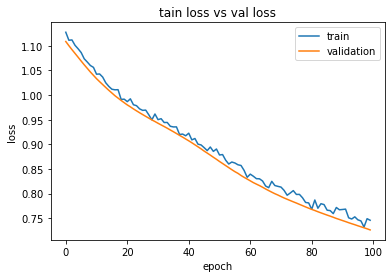

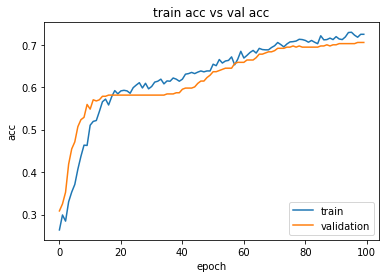

[[ 70   0  40]
 [ 46   0  14]
 [ 17   0 266]]
Accuracy: 0.7417218543046358
F1: 0.6910656973221267
Precision: 0.647104827466016
Recall: 0.7417218543046358


C:\Users\Jonathan\anaconda3\envs\NewDeep\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
plotLoss()
plotAcc()
evalModel(yTrue, yPred)

In [121]:
#unfreeze embedding layer
for layer in model.layers[:]:
    print(layer, layer.trainable)

for layer in model.layers[1:2]:
    layer.trainable = True

for layer in model.layers[:]:
    print(layer, layer.trainable)

#decrease learning rate, compile, and train model again for a few more epochs
opt = Adam(1e-7)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(pad_trunc_Text,y_train,epochs=20,batch_size=32,validation_split=0.2,callbacks=early_stop,shuffle=True)
model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001CD1184B1F0> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CD1184B2B0> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001CD87A0FDC0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x000001CD861C4B20> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001CD861D2220> True
<tensorflow.python.keras.layers.core.Dropout object at 0x000001CD96BC0EB0> True
<tensorflow.python.keras.layers.core.Dense object at 0x000001CD96A606A0> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001CD1184B1F0> True
<tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001CD1184B2B0> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001CD87A0FDC0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x000001CD861C4B20> True
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x000001CD

### Building a BERT model

In [2]:
#get tokenizer and bert model from huggingFace
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_layer = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#set max length of sentences to be tokenized
MAX_SEQ_LEN=100

#create lists for encoded inputs
def getTokens(sents):
    input_idst = []
    attention_maskst = []
    i = 0
    for sentence in sents:
        encoded_new = tokenizer.encode_plus(
                                            sentence,                      
                                            add_special_tokens = True,  
                                            padding = 'max_length',
                                            max_length = MAX_SEQ_LEN,             
                                            truncation=True,
                                            return_attention_mask = True,     
                                            #return_tensors = 'tf'        
                                            )
        input_idst.append(encoded_new['input_ids'])
        attention_maskst.append(encoded_new['attention_mask'])
        print(i)
        i += 1
        
    return input_idst, attention_maskst
    
input_idst, attention_maskst = getTokens(xTrain)

#reshape inputs
input_idst = np.reshape(np.array(input_idst),(len(xTrain),-1))
attention_maskst = np.reshape(attention_maskst,(len(xTrain),-1))

In [ ]:
#build model
np.random.seed(37)
tf.random.set_seed(37)

inputs = dict(input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='input_token', dtype='int32'),
              input_masks_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='masked_token', dtype='int32')
              )
sequence_output = bert_layer.bert(inputs)["last_hidden_state"]
x = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(sequence_output)
x = tf.keras.layers.Dense(10)(x)
#x = tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
out = tf.keras.layers.Dense(3,activation="softmax")(x)
model = tf.keras.Model(inputs=(inputs), outputs=out)

#freeze bert_layer (can be partially or fully unfrozen and fine-tuned after initial training)
for layer in model.layers[2:3]:
    layer.trainable=False
    print(layer, layer.trainable)

#compile, fit, summarize, and plot model
model.compile(loss='categorical_crossentropy', optimizer=Adam(6e-4), metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit([input_idst,attention_maskst],yTrain,epochs=80 ,validation_split=0.2, callbacks=early_stop, batch_size=32,shuffle=True)
tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

In [ ]:
for layer in model.layers[2:3]:
    layer.trainable=True
    print(layer, layer.trainable)

for layer in bert_layer.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
       for layer in layer.encoder.layer[:7]:
            layer.trainable = False
            print(layer, layer.trainable)

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
history = model.fit([input_idst,attention_maskst],yTrain,epochs=4 ,validation_split=0.2, batch_size=32, shuffle=True)

In [ ]:
for layer in model.layers[2:3]:
    layer.trainable=True
    print(layer, layer.trainable)

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-6), metrics=['accuracy'])
history = model.fit([input_idst,attention_maskst],yTrain,epochs=8 ,validation_split=0.2, batch_size=32, shuffle=True)

In [ ]:
#encode test set
input_idstTest, attention_maskstTest = getTokens(xTest)

#reshape inputs
input_idstTest = np.reshape(np.array(input_idstTest),(len(xTest),-1))
attention_maskstTest = np.reshape(attention_maskstTest,(len(xTest),-1))

#get predictions for test 
yPred = model.predict([input_idstTest,attention_maskstTest])
yPred = np.argmax(yPred, axis = 1)
yTrue = np.argmax(np.array(yTest), axis=1)

#evaluation funcs
def evalModel(yTrue, yPred):
    print(confusion_matrix(yTrue,yPred))
    print("Accuracy:", accuracy_score(yTrue,yPred))
    print("F1:", f1_score(yTrue,yPred, average='weighted'))
    print("Precision:", precision_score(yTrue,yPred, average='weighted'))
    print("Recall:", recall_score(yTrue,yPred, average='weighted'))   

def plotLoss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('tain loss vs val loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def plotAcc():
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('train acc vs val acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

plotLoss()
plotAcc()
evalModel(yTrue,yPred)

In [ ]:
#save and load model
#model.save('my_FinBERT_96289', save_format='tf')
#model2 = tf.keras.models.load_model("my_FinBERT")
#model2.summary()

#look at/modify layers in model and/or bert_layer for fine-tuning, then compile and train more
for layer in model.layers[:]:
    #layer.trainable=True
    print(layer, layer.trainable)
        
for layer in bert_layer.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
       for layer in layer.encoder.layer[:]:
            #layer.trainable = False
            print(layer, layer.trainable)

for layer in bert_layer.layers[:]:
    if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
       for idx, layer in enumerate(layer.encoder.layer):
           if idx in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
              #layer.trainable = False
              print(layer, layer.trainable)

# DATA PREPARATION

In [7]:
#Use fine-tuned bert model to get sentiments for 'title' and 'description' of articles
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = tf.keras.models.load_model("my_FinBERT_96289")

In [142]:
#Tokenize text, get sentiments from model, and add sentiments to dataframe
def sentScore(dfNews):
    df = dfNews.copy()
    
    MAX_SEQ_LEN = 100
    #class_names = ['positive', 'negative', 'neutral']
    i = 0
    
    start = time.time()
    #create lists for encoded inputs
    def getTokens(sents):
        input_idst = []
        attention_maskst = []
        i = 0
        for sentence in sents:
            encoded_new = tokenizer.encode_plus(
                                                sentence,                      
                                                add_special_tokens = True,  
                                                padding = 'max_length',
                                                max_length = MAX_SEQ_LEN,             
                                                truncation=True,
                                                return_attention_mask = True,     
                                                #return_tensors = 'tf'        
                                                )
            input_idst.append(encoded_new['input_ids'])
            attention_maskst.append(encoded_new['attention_mask'])
            print(i)
            i += 1
            
        return input_idst, attention_maskst
        
    input_idst, attention_maskst = getTokens(df['title'])
    
    #reshape inputs
    input_idst = np.reshape(np.array(input_idst),(len(df['title']),-1))
    attention_maskst = np.reshape(attention_maskst,(len(df['title']),-1))
    
    pred = model.predict([input_idst,attention_maskst])
        
    df['pos'] = pred[:, 0].round(4).astype('float64')
    df['neg'] = pred[:, 1].round(4).astype('float64')
    df['neut'] = pred[:, 2].round(4).astype('float64')
    
    
    input_idst, attention_maskst = getTokens(df['description'])
    
    #reshape inputs
    input_idst = np.reshape(np.array(input_idst),(len(df['description']),-1))
    attention_maskst = np.reshape(attention_maskst,(len(df['description']),-1))
    
    pred = model.predict([input_idst,attention_maskst])
        
    df['posDes'] = pred[:, 0].round(4).astype('float64')
    df['negDes'] = pred[:, 1].round(4).astype('float64')
    df['neutDes'] = pred[:, 2].round(4).astype('float64')

    return df
'''
dfamznNewsWsent = sentScore(dfamznNews)
dfaaplNewsWsent = sentScore(dfaaplNews)
dfgoogNewsWsent = sentScore(dfgoogNews)

dfamznNewsWsent.to_csv('data/amznNewsWsent.csv')
dfaaplNewsWsent.to_csv('data/aaplNewsWsent.csv')
dfgoogNewsWsent.to_csv('data/googNewsWsent.csv')
'''


"\ndfamznNewsWsent = sentScore(dfamznNews)\ndfaaplNewsWsent = sentScore(dfaaplNews)\ndfgoogNewsWsent = sentScore(dfgoogNews)\n\ndfamznNewsWsent.to_csv('data/amznNewsWsent.csv')\ndfaaplNewsWsent.to_csv('data/aaplNewsWsent.csv')\ndfgoogNewsWsent.to_csv('data/googNewsWsent.csv')\n"

In [123]:
#import news with sentiment df 
def impNewsWSent(path):
    df = pd.read_csv(str(path), index_col=(0))
    for j in range(len(df)):
        df.loc[j,'date'] = parse(df['date'][j])
    return df
        
dfamznNewsWsent = impNewsWSent('data/amznNewsWsent.csv')
dfaaplNewsWsent = impNewsWSent('data/aaplNewsWsent.csv')
dfgoogNewsWsent = impNewsWSent('data/googNewsWsent.csv')

dfamznNewsWsent.head()
dfaaplNewsWsent.head()
dfgoogNewsWsent.head()

,date,title,description,source,pos,neg,neut,posDes,negDes,neutDes
0,2021-01-29 11:37:10-08:00,Google CMO: Focus on consumer is best way to f...,As Alphabet's Google faces government antitrus...,CNBC,0.1018,0.0795,0.8186,0.4073,0.1178,0.4749
1,2021-01-29 08:55:10-08:00,"EU lawmakers, Amazon, Apple, Facebook, Google ...","EU lawmakers, who are gearing up to curb the p...",Reuters,0.0928,0.7185,0.1887,0.2492,0.4183,0.3325
2,2021-01-28 23:39:00-08:00,Google Works To Restore Robinhood's Reputation...,Alphabet Inc (NASDAQ: GOOGL) (NASDAQ: GOOG) su...,Benzinga,0.0114,0.0095,0.9791,0.0192,0.2801,0.7008
3,2021-01-28 12:01:14.162000-08:00,Google CEO Says Internal Rancor Over AI Due to...,Alphabet Inc. Chief Executive Officer Sundar P...,Bloomberg,0.0578,0.0218,0.9203,0.4547,0.0958,0.4496
4,2021-01-28 11:10:00-08:00,"DraftKings, Penn power higher after Google wel...",DraftKings (DKNG +3.5%) and Penn National Gami...,Seeking Alpha,0.9435,0.0143,0.0423,0.3223,0.0321,0.6457


In [143]:
#create empty df and sort articles for each time step then get average
def dividingFunc(dfNewsWsent, dfStock):
        
    NewsSortedTitle = np.zeros(shape=(len(dfStock),500,3))
    NewsSortedDescrip = np.zeros(shape=(len(dfStock),500,3))
    
    NewsSortedTitleText = []
    NewsSortedDescripText = []
    i = 0
    while i < len(dfStock):
        NewsSortedTitleText.append([])
        NewsSortedDescripText.append([])
        i += 1
    
    for i in range(len(dfStock)-1):
        k = 0
        for j in range(len(dfNewsWsent)):
            if ((dfNewsWsent['date'][j]) < dfStock['date'][i+1]) and ((dfNewsWsent['date'][j]) > dfStock['date'][i]):
                NewsSortedTitle[i,k]=np.array([dfNewsWsent['pos'][j],dfNewsWsent['neut'][j],dfNewsWsent['neg'][j]])
                NewsSortedDescrip[i,k]=np.array([dfNewsWsent['posDes'][j],dfNewsWsent['neutDes'][j],dfNewsWsent['negDes'][j]])
                NewsSortedTitleText[i].append(dfNewsWsent['title'][j])
                NewsSortedDescripText[i].append(dfNewsWsent['description'][j])
                
                k+=1
        print(i)
    
    #get averages of sentiments to use as features
    tCnt = np.count_nonzero(NewsSortedTitle, axis=1)
    tSum = np.sum(NewsSortedTitle, axis=1)
    tAve = tSum/tCnt
    
    dCnt = np.count_nonzero(NewsSortedDescrip, axis=1)
    dSum = np.sum(NewsSortedDescrip, axis=1)
    dAve = dSum/dCnt
    
    #tAve = pd.DataFrame(tAve)
    #dAve = pd.DataFrame(dAve)
    
    return tAve, dAve, tCnt, dCnt, NewsSortedTitle, NewsSortedDescrip, NewsSortedTitleText, NewsSortedDescripText


'''
amznSentInfo = dividingFunc(dfamznNewsWsent, dfamzn)
aaplSentInfo = dividingFunc(dfaaplNewsWsent, dfaapl)
googSentInfo = dividingFunc(dfgoogNewsWsent, dfgoog)


pickle.dump(amznSentInfo, open('data/amznInfo.csv', 'wb'))
pickle.dump(aaplSentInfo, open('data/aaplInfo.csv', 'wb'))
pickle.dump(googSentInfo, open('data/googInfo.csv', 'wb'))

amznSentInfo = pickle.load(open('data/amznInfo.csv', 'rb'))
aaplSentInfo = pickle.load(open('data/aaplInfo.csv', 'rb'))
googSentInfo = pickle.load(open('data/googInfo.csv', 'rb'))
'''

"\namznSentInfo = dividingFunc(dfamznNewsWsent, dfamzn)\naaplSentInfo = dividingFunc(dfaaplNewsWsent, dfaapl)\ngoogSentInfo = dividingFunc(dfgoogNewsWsent, dfgoog)\n\n\npickle.dump(amznSentInfo, open('data/amznInfo.csv', 'wb'))\npickle.dump(aaplSentInfo, open('data/aaplInfo.csv', 'wb'))\npickle.dump(googSentInfo, open('data/googInfo.csv', 'wb'))\n\namznSentInfo = pickle.load(open('data/amznInfo.csv', 'rb'))\naaplSentInfo = pickle.load(open('data/aaplInfo.csv', 'rb'))\ngoogSentInfo = pickle.load(open('data/googInfo.csv', 'rb'))\n"

In [25]:
#import stock vix's
def importStockvix(path):
    df = pd.read_csv(str(path), header=1)
    df = df[2180:].reset_index(drop=True)
    for j in range(len(df)):
        df.loc[j,'Date'] = parse(df['Date'][j])
    return df

vxamzn = importStockvix('data/vxamzndailyprices.csv')
vxaapl = importStockvix('data/vxaapldailyprices.csv')
vxgoog = importStockvix('data/vxgoogdailyprices.csv')

vxamzn.head()

,Date,Open,High,Low,Close
0,2019-01-29 00:00:00,42.11,43.88,41.68,42.32
1,2019-01-30 00:00:00,41.72,42.08,38.34,39.29
2,2019-01-31 00:00:00,39.73,39.73,38.00,38.69
3,2019-02-01 00:00:00,32.53,34.56,30.66,32.53
4,2019-02-04 00:00:00,32.53,33.37,29.72,30.40


In [144]:
#add vix and sentiment features to 30min stock df
def addingDailyFeatures(vxStock, dfStock, tAve, dAve, tCnt):
    dfStock = dfStock.copy()
    dfStock.loc[:,'vixOpen'] = 0
    dfStock.loc[:,'vixHigh'] = 0
    dfStock.loc[:,'vixLow'] = 0
    dfStock.loc[:,'vixClose'] = 0
    for i in range(len(dfStock)):
        for j in range(len(vxStock)):
            if dfStock.loc[i,'date'].date()==vxStock.loc[j,'Date'].date():
                dfStock.loc[i,'vixOpen'] = vxStock.loc[j,'Open']
                dfStock.loc[i,'vixHigh'] = vxStock.loc[j,'High']
                dfStock.loc[i,'vixLow'] = vxStock.loc[j,'Low']
                dfStock.loc[i,'vixClose'] = vxStock.loc[j,'Close']
                print(i)
                break
    dfStock['tPos'] = tAve[:,0]
    dfStock['tNeut'] = tAve[:,1]
    dfStock['tNeg'] = tAve[:,2]
    dfStock['dPos'] = dAve[:,0]
    dfStock['dNeut'] = dAve[:,1]
    dfStock['dNeg'] = dAve[:,2]
    dfStock['artCnt'] = tCnt[:,0]
    return dfStock

'''
dfamzn = addingDailyFeatures(vxamzn, dfamzn, amznSentInfo[0], amznSentInfo[1], amznSentInfo[2])
dfaapl= addingDailyFeatures(vxaapl, dfaapl, aaplSentInfo[0], aaplSentInfo[1], aaplSentInfo[2])
dfgoog = addingDailyFeatures(vxgoog, dfgoog, googSentInfo[0], googSentInfo[1], googSentInfo[2])
'''

'\ndfamzn = addingDailyFeatures(vxamzn, dfamzn, amznSentInfo[0], amznSentInfo[1], amznSentInfo[2])\ndfaapl= addingDailyFeatures(vxaapl, dfaapl, aaplSentInfo[0], aaplSentInfo[1], aaplSentInfo[2])\ndfgoog = addingDailyFeatures(vxgoog, dfgoog, googSentInfo[0], googSentInfo[1], googSentInfo[2])\n'

In [38]:
#add weekday features to df
def addWeekday(dfStock):
    df = dfStock.copy()
    df['weekday'] = 0
    for i in range(len(df['date'])):
        df.loc[i,'weekday'] = df['date'][i].weekday()
    return df

dfamzn = addWeekday(dfamzn)
dfaapl = addWeekday(dfaapl)
dfgoog = addWeekday(dfgoog)

In [39]:
#read in spy and vix
dfspy = pd.read_csv('data/30MinSPY2yrs.csv', index_col=(0))
vxspy = pd.read_csv('data/VIX_NEW_YAHOO.csv')
vxspy = vxspy[743:].reset_index(drop=True)

for j in range(len(dfspy)):
    dfspy.loc[j,'date'] = parse(dfspy['date'][j])
    
for j in range(len(vxspy)):
    vxspy.loc[j,'Date'] = parse(vxspy['Date'][j])

In [145]:
#add vix to 30 min spy
def addingDailyVixToSpy(vxStock, dfStock):
    dfStock = dfStock.copy()
    dfStock.loc[:,'vixOpen'] = 0
    dfStock.loc[:,'vixHigh'] = 0
    dfStock.loc[:,'vixLow'] = 0
    dfStock.loc[:,'vixClose'] = 0
    for i in range(len(dfStock)):
        for j in range(len(vxStock)):
            if dfStock.loc[i,'date'].date()==vxStock.loc[j,'Date'].date():
                dfStock.loc[i,'vixOpen'] = vxStock.loc[j,'Open']
                dfStock.loc[i,'vixHigh'] = vxStock.loc[j,'High']
                dfStock.loc[i,'vixLow'] = vxStock.loc[j,'Low']
                dfStock.loc[i,'vixClose'] = vxStock.loc[j,'Close']
                print(i)
                break
    return dfStock
'''
dfspyWvix = addingDailyVixToSpy(vxspy, dfspy)
'''

'\ndfspyWvix = addingDailyVixToSpy(vxspy, dfspy)\n'

In [124]:
#split df into train/test
def trainTestSplit(dfStock):
    df = dfStock.copy()
    dfTrain = df[:4000]
    dfTest = df[4000:].reset_index(drop=True)
    return dfTrain, dfTest

dfamznTrain, dfamznTest = trainTestSplit(dfamzn)
dfaaplTrain, dfaaplTest = trainTestSplit(dfaapl)
dfgoogTrain, dfgoogTest = trainTestSplit(dfgoog)
dfspyTrain, dfspyTest = trainTestSplit(dfspyWvix)

In [125]:
#Create return features and target columns
def creatingReturnFeat(dfStock, vixRandom = False):
    df = dfStock.copy()
    #create vix-based return features
    df.loc[df.volume==0,'volume']=df['volume'].mean()
    for i in range(len(df.vixOpen)):
        df.loc[i,'vixRand'] = (np.random.random()*(df.loc[i,'vixHigh']-df.loc[i,'vixLow']))+df.loc[i,'vixLow']
    df['vixAve'] = (df.vixHigh+df.vixLow)/2
    vixTimestep = 14000
    if vixRandom == True:
        vixToUse = df.vixRand/100
    else:
        vixToUse = df.vixAve/100
    df['close_open'] = np.log(df.close/df.opn)/(vixToUse/math.sqrt(vixTimestep))
    df['high_open'] = np.log(df.high/df.opn)/(vixToUse/math.sqrt(vixTimestep))
    df['low_open'] = np.log(df.opn/df.low)/(vixToUse/math.sqrt(vixTimestep))
    #create vix-based magnitude target
    df['large'] = 0
    df['small'] = 0
    df['magnitude'] = abs(np.log(df.close/df.opn))/(vixToUse/math.sqrt(vixTimestep))
    df.loc[(df.magnitude >= 0.675), 'large'] = 1
    df.loc[(df.magnitude < 0.675), 'small'] = 1
    for i in range(len(df['volume'])-1):
        df.loc[i+1,'volPercent'] = np.log(df.loc[i+1,'volume']/df.loc[i,'volume'])
    df['vixClose'] = df.vixClose/100
    #create direction target
    df['up'] = 0
    df['down'] = 0
    df.loc[(df.close_open >= 0), 'up'] = 1
    df.loc[(df.close_open < 0), 'down'] = 1 
    return df

dfamznTrain = creatingReturnFeat(dfamznTrain)
dfaaplTrain = creatingReturnFeat(dfaaplTrain)
dfgoogTrain = creatingReturnFeat(dfgoogTrain)
dfspyTrain = creatingReturnFeat(dfspyTrain)

In [126]:
#add spy to dfs
def addSpy(dfStock, dfspy=dfspyTrain):
    dfStock = dfStock.copy()
    dfspy = dfspy.copy()
    dfStock['spy_close_open'] = dfspy['close_open']
    dfStock['spy_high_open'] = dfspy['high_open']
    dfStock['spy_low_open'] = dfspy['low_open']
    dfStock['spy_vix'] = dfspy['vixClose']
    return dfStock

dfamznTrain = addSpy(dfamznTrain)
dfaaplTrain = addSpy(dfaaplTrain)
dfgoogTrain = addSpy(dfgoogTrain)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   opn             4000 non-null   float64
 1   high            4000 non-null   float64
 2   low             4000 non-null   float64
 3   close           4000 non-null   float64
 4   volume          4000 non-null   float64
 5   epochDate       4000 non-null   int64  
 6   date            4000 non-null   object 
 7   vixOpen         4000 non-null   float64
 8   vixHigh         4000 non-null   float64
 9   vixLow          4000 non-null   float64
 10  vixClose        4000 non-null   float64
 11  tPos            1681 non-null   float64
 12  tNeg            1681 non-null   float64
 13  tNeut           1681 non-null   float64
 14  dPos            1681 non-null   float64
 15  dNeg            1681 non-null   float64
 16  dNeut           1680 non-null   float64
 17  artCnt          4000 non-null   i

array([[<AxesSubplot:title={'center':'opn'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'volume'}>,
        <AxesSubplot:title={'center':'epochDate'}>],
       [<AxesSubplot:title={'center':'vixOpen'}>,
        <AxesSubplot:title={'center':'vixHigh'}>,
        <AxesSubplot:title={'center':'vixLow'}>,
        <AxesSubplot:title={'center':'vixClose'}>,
        <AxesSubplot:title={'center':'tPos'}>,
        <AxesSubplot:title={'center':'tNeg'}>],
       [<AxesSubplot:title={'center':'tNeut'}>,
        <AxesSubplot:title={'center':'dPos'}>,
        <AxesSubplot:title={'center':'dNeg'}>,
        <AxesSubplot:title={'center':'dNeut'}>,
        <AxesSubplot:title={'center':'artCnt'}>,
        <AxesSubplot:title={'center':'weekday'}>],
       [<AxesSubplot:title={'center':'vixRand'}>,
        <AxesSubplot:title={'center':'vixAve'}>,
        <AxesSubplot:title=

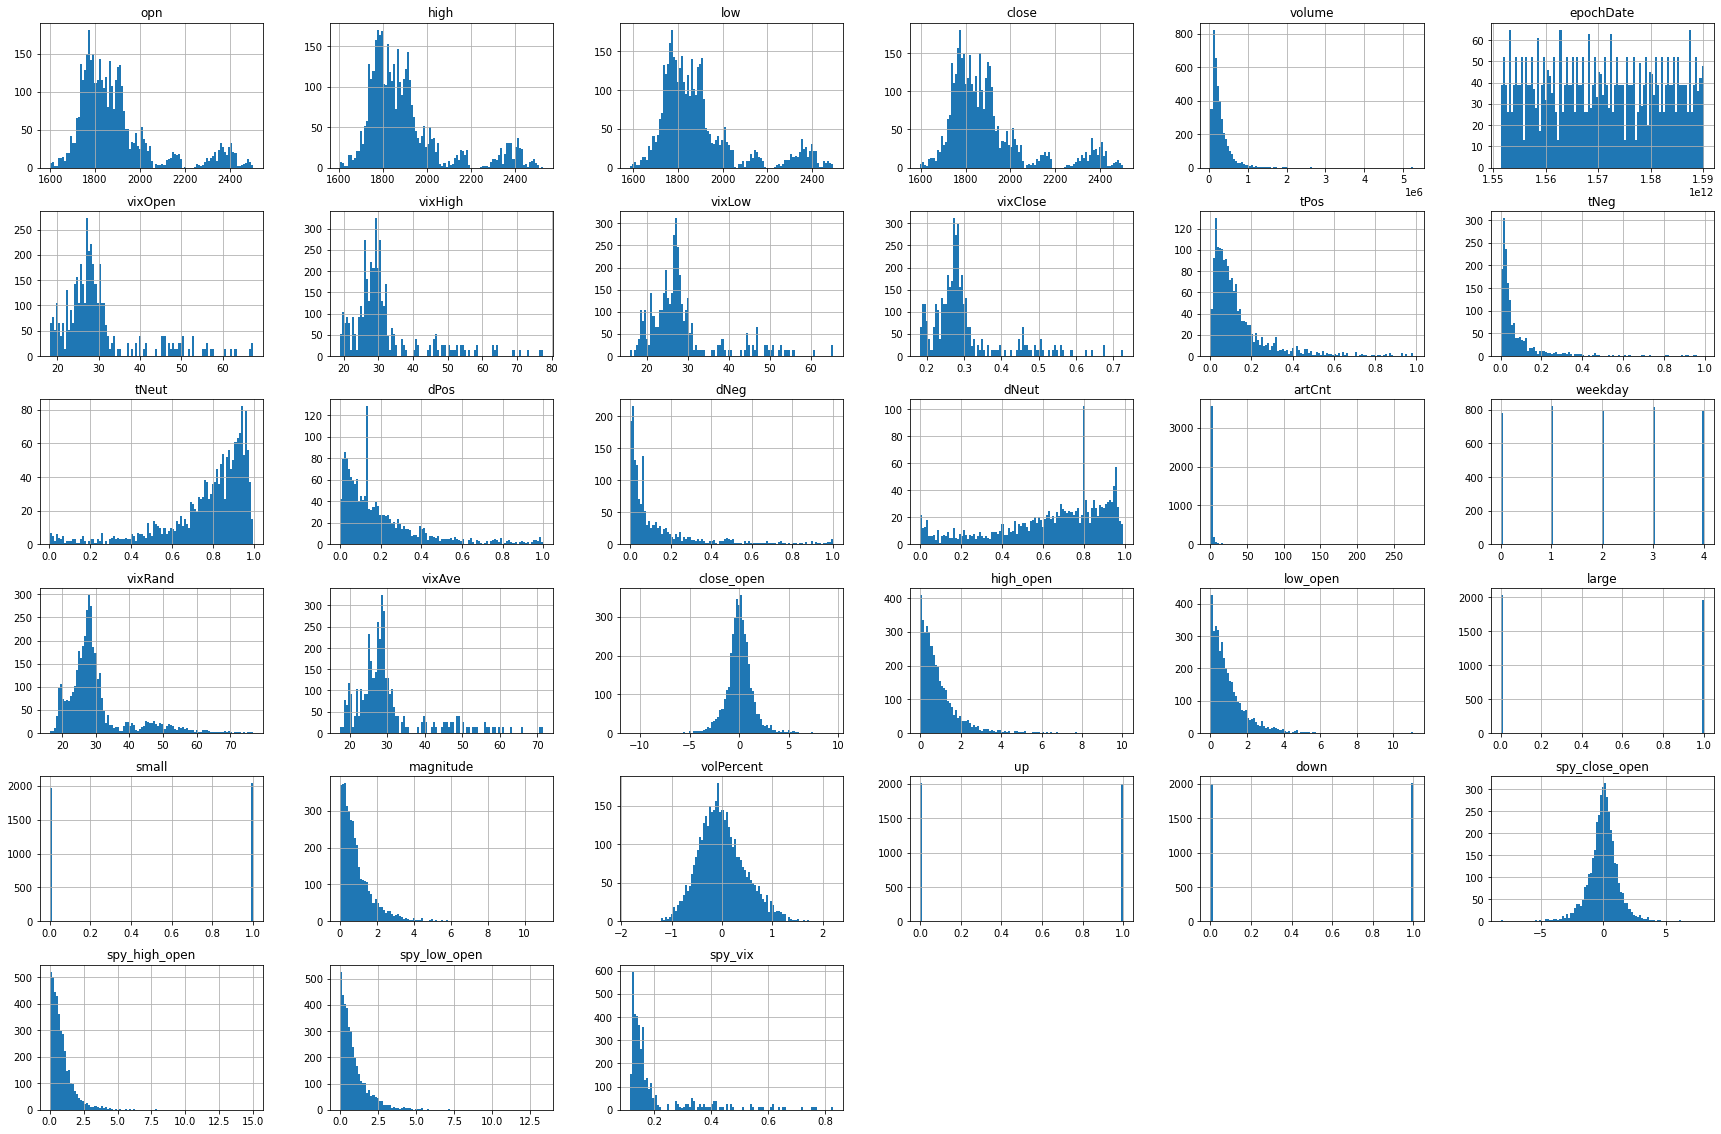

In [127]:
#explore df
dfamznTrain.head()
dfamznTrain.info()
dfamznTrain['large'].value_counts()
dfamznTrain['up'].value_counts()
dfamznTrain.describe()
dfamznTrain.hist(bins=100, figsize=(30,20))
#scatMat = pd.plotting.scatter_matrix(dfamznTrain)

In [128]:
#shift target column and drop last row 
def shiftTarget(dfStock, train=True):
    df = dfStock.copy()
    df['large'] = df['large'].shift(-1)
    df['small'] = df['small'].shift(-1)
    df['up'] = df['up'].shift(-1)
    df['down'] = df['down'].shift(-1)
    if train == True:        
        return df[78:(len(df)-1)].reset_index(drop=True)
    else:
        return df[1:(len(df)-1)].reset_index(drop=True)

dfamznShiftedTarTrain = shiftTarget(dfamznTrain)
dfaaplShiftedTarTrain = shiftTarget(dfaaplTrain)
dfgoogShiftedTarTrain = shiftTarget(dfgoogTrain)

In [129]:
#combine train sets
def combTrainSet(*args):
    frms = [*args]
    combinedTrain = pd.concat(frms).reset_index(drop=True)
    return combinedTrain

combinedTrain = combTrainSet(dfamznShiftedTarTrain, dfaaplShiftedTarTrain, dfgoogShiftedTarTrain)

In [130]:
#fill Nan for missing sentiments - Train and Test
def fillNA(df):
    df = df.copy()
    df['tNeg'].fillna(0, inplace=True)
    df['tNeut'].fillna(1, inplace=True)
    df['tPos'].fillna(0, inplace=True)
    df['dNeg'].fillna(0, inplace=True)
    df['dNeut'].fillna(1, inplace=True)
    df['dPos'].fillna(0, inplace=True)
    return df

combinedTrainNoNa = fillNA(combinedTrain)

In [131]:
#build column transformer pipeline
def createPipeline(combinedTrainNoNa, minMax = False):
    dfTrain = combinedTrainNoNa.copy().drop(['large','small','up','down'], axis=1)
    dfTrainTargets = combinedTrainNoNa.copy()[['large','small','up','down']]
    
    sentiments = ['tNeg','tNeut','tPos','dNeg','dNeut','dPos']
    logReturns = ['close_open','high_open','low_open','spy_close_open',
                  'spy_high_open', 'spy_low_open','volPercent']
    weekday = ['weekday']
    artCnt = ['artCnt']
    vix = ['vixClose','spy_vix']
    
    if minMax == False:
        full_pipeline = ColumnTransformer([
            ("sent", StandardScaler(), sentiments),
            ("artCnt", StandardScaler(), artCnt),
            ("ret", StandardScaler(), logReturns),
            ("weekday", OneHotEncoder(), weekday),
            ("vix", StandardScaler(), vix)
            ]) 
    else:
        full_pipeline = ColumnTransformer([
            ("sent", MinMaxScaler(), sentiments),
            ("artCnt", MinMaxScaler(), artCnt),
            ("ret", MinMaxScaler(), logReturns),
            ("weekday", OneHotEncoder(), weekday),
            ("vix", MinMaxScaler(), vix)
            ])         
    
    transformedTrainSet = full_pipeline.fit_transform(dfTrain)
    transformedTrainSet = transformedTrainSet, dfTrainTargets

    return transformedTrainSet, full_pipeline
        
transformedTrainSet, full_pipeline = createPipeline(combinedTrainNoNa)

In [132]:
#prep and transform test sets
dfspyTest = creatingReturnFeat(dfspyTest)
def prepTestData(dfTest):
    df = dfTest.copy()
    df = creatingReturnFeat(df)
    df = addSpy(df, dfspy=dfspyTest)
    df = shiftTarget(df, train=False)
    df = fillNA(df)
    dfNoTarget = df.copy().drop(['large','small','up','down'], axis=1)
    testTargets = df.copy()[['large','small','up','down']]
    transformedTestSet = full_pipeline.transform(dfNoTarget)      
    return transformedTestSet, testTargets

amznTransformedTestSet = prepTestData(dfamznTest)
aaplTransformedTestSet = prepTestData(dfaaplTest)
googTransformedTestSet = prepTestData(dfgoogTest)

In [133]:
#shuffle datasets
def shuffleData(tup):
    shuffledData = shuffle(tup[0], tup[1], random_state=37)
    return shuffledData

shufTrainSet = shuffleData(transformedTrainSet)
amznShufTestSet = shuffleData(amznTransformedTestSet)
aaplShufTestSet = shuffleData(aaplTransformedTestSet)
googShufTestSet = shuffleData(googTransformedTestSet)

preppedMagData = (shufTrainSet[0], np.array(shufTrainSet[1][['large','small']]),
                  amznShufTestSet[0], np.array(amznShufTestSet[1][['large','small']]),
                  aaplShufTestSet[0], np.array(aaplShufTestSet[1][['large','small']]),
                  googShufTestSet[0], np.array(googShufTestSet[1][['large','small']]))

preppedDirData = (shufTrainSet[0], np.array(shufTrainSet[1][['up','down']]),
                  amznShufTestSet[0], np.array(amznShufTestSet[1][['up','down']]),
                  aaplShufTestSet[0], np.array(aaplShufTestSet[1][['up','down']]),
                  googShufTestSet[0], np.array(googShufTestSet[1][['up','down']]))

# BUILD AND EVALUATE MODELS

In [134]:
#functions to evaluate models and learning curves
def evalModel(yTrue, yPred):
    print(confusion_matrix(yTrue,yPred))
    print("Accuracy:", accuracy_score(yTrue,yPred))
    print("F1:", f1_score(yTrue,yPred))
    print("Precision:", precision_score(yTrue,yPred))
    print("Recall:", recall_score(yTrue,yPred))   

def plotRocCurve(yTrue, yPred):
    fpr, tpr, thresholds = roc_curve(yTrue, yPred)
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    plt.show()
    print("AUC:", roc_auc_score(yTrue,yPred))   

def plotPrecRecall(yTrue, yPred):
    precisions, recalls, thresholds = precision_recall_curve(yTrue, yPred)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()

def plotLoss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('tain loss vs val loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def plotAcc():
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('train acc vs val acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [135]:
#training and evaluation function
def trainEvalFunc(param_grid, est, n_iter, decFunc=True, xTrain=preppedMagData[0], 
                  yTrain=np.argmax(preppedMagData[1], axis=1),xTest=preppedMagData[6],
                  yTest=np.argmax(preppedMagData[7], axis=1)):

    RGS = RandomizedSearchCV(est, param_grid, n_iter=n_iter, cv=5, scoring='accuracy', return_train_score=True)
    RGS.fit(xTrain, yTrain)
    
    bestParams = RGS.best_params_
    bestEst = RGS.best_estimator_
    results = RGS.cv_results_
    dfResults = pd.DataFrame(results)
    
    for mean_score, params in zip(results["mean_test_score"], results["params"]):
        print(mean_score, params)
    
    if decFunc == True:
        evalModel(yTest, bestEst.predict(xTest))
        plotPrecRecall(yTest, bestEst.decision_function(xTest))
        plotRocCurve(yTest, bestEst.decision_function(xTest))
    else:
        evalModel(yTest, bestEst.predict(xTest))
        plotPrecRecall(yTest, bestEst.predict_proba(xTest)[:,1])
        plotRocCurve(yTest, bestEst.predict_proba(xTest)[:,1])
    
    return bestParams, bestEst, dfResults

0.598486047627721 {'alpha': 0.0001, 'eta0': 0.2, 'loss': 'hinge', 'penalty': 'l1'}
0.6063934158448759 {'alpha': 0.001, 'eta0': 0.0, 'loss': 'log', 'penalty': 'l2'}
0.6061388558823444 {'alpha': 0.0001, 'eta0': 0.0, 'l1_ratio': 0.34130952591055463, 'loss': 'hinge', 'penalty': 'elasticnet'}
0.49757951204281115 {'alpha': 1000, 'eta0': 0.0, 'l1_ratio': 0.9002707188360076, 'loss': 'perceptron', 'penalty': 'elasticnet'}
0.4976645099178644 {'alpha': 10, 'eta0': 0.2, 'loss': 'log', 'penalty': 'l2'}
0.6063934158448759 {'alpha': 0.001, 'eta0': 0.1, 'loss': 'log', 'penalty': 'l2'}
0.5314950374539956 {'alpha': 0.0001, 'eta0': 0.2, 'loss': 'perceptron', 'penalty': 'l2'}
0.6063934158448759 {'alpha': 0.001, 'eta0': 0.1, 'loss': 'log', 'penalty': 'l2'}
0.5926239046404792 {'alpha': 0.0001, 'eta0': 0.1, 'loss': 'log', 'penalty': 'l2'}
0.49757951204281115 {'alpha': 1000, 'eta0': 0.0, 'loss': 'perceptron', 'penalty': 'l2'}
0.5308137173271349 {'alpha': 10, 'eta0': 0.2, 'loss': 'perceptron', 'penalty': 'l2'}

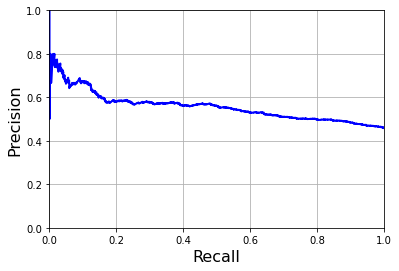

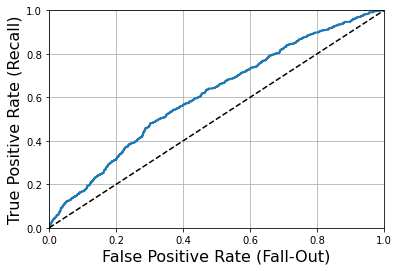

AUC: 0.6106826487637991


In [136]:
#SGD - SVM, logReg, perceptron
param_grid = [
    {'loss': ['hinge', 'log', 'perceptron'], 'penalty': ['l2', 'l1'], 
     'alpha': [0.0001,0.001,0.01,0.1,1,10,100,1000], 'eta0':[0.0, 0.1, 0.2]},
    {'loss': ['hinge', 'log', 'perceptron'], 'penalty': ['elasticnet'], 
     'l1_ratio': uniform(0,1), 'alpha': [0.0001,0.001,0.01,0.1,1,10,100,1000], 'eta0':[0.0, 0.1, 0.3]},
    ]
est = SGDClassifier(random_state=42, max_iter=2000)
n_iter = 60
resSGD = trainEvalFunc(param_grid, est, n_iter)

0.6191470362050472 {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.6192320702186527 {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
0.6199120532190776 {'l1_ratio': 0.281887042646065, 'penalty': 'elasticnet', 'solver': 'saga'}
0.6199970510941307 {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.6154905374814609 {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.6191470362050472 {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.6191470362050472 {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.6193176101719906 {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}
0.6196570957324706 {'l1_ratio': 0.16221680598471067, 'penalty': 'elasticnet', 'solver': 'saga'}
0.6201671191213417 {'l1_ratio': 0.5845191456247727, 'penalty': 'elasticnet', 'solver': 'saga'}
[[660 557]
 [408 613]]
Accuracy: 0.5688114387846291
F1: 0.5595618439068918
Precision: 0.523931623931624
Recall: 0.6003917727717923


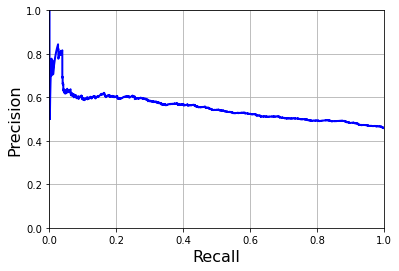

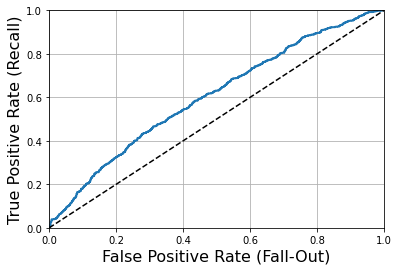

AUC: 0.6041477372869011


In [78]:
#logistic regression model with grid search and cross validation
param_grid = [
    {'solver': ['lbfgs', 'sag'], 'penalty': ['l2'], 'C': [0.0001,0.001,0.01,0.1,1,10,100,1000]},
    {'solver': ['liblinear'], 'penalty': ['l1'], 'C': [0.0001,0.001,0.01,0.1,1,10,100,1000]},
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'l1_ratio': uniform(0,1)},
    ]
est = LogisticRegression(random_state=42, max_iter=2000)
n_iter = 60
resLogReg = trainEvalFunc(param_grid, est, n_iter)

0.5992535582018613 {'n_neighbors': 300}
0.5796146040226546 {'n_neighbors': 7}
[[506 711]
 [275 746]]
Accuracy: 0.5594280607685433
F1: 0.6020984665052461
Precision: 0.5120109814687714
Recall: 0.7306562193927522


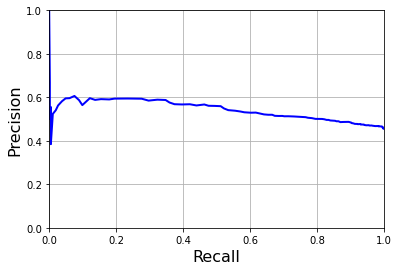

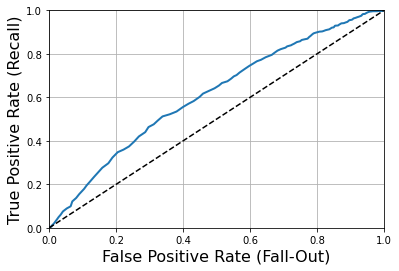

AUC: 0.610691501476391


In [79]:
#KNeighbors
param_grid = [
    {'n_neighbors': [3,5,7,10,15,20,40,80,120,160,200,300]},
    ]
est = KNeighborsClassifier()
n_iter = 12
resKNN = trainEvalFunc(param_grid, est, n_iter, decFunc=False)

In [ ]:
#SVM models with multiple kernels
param_grid = [
    {'kernel': ['rbf'], 'C': [0.0001,0.001,0.01,0.1,1,10,100,1000]},
    {'kernel': ['poly'], 'degree': [2, 3, 5],'coef0': [0.0, 0.5, 1, 5], 
     'C': [0.0001,0.001,0.01,0.1,1,10,100,1000]}
    ]
est = SVC(probability=True, max_iter=2000)
n_iter = 2
resSVM = trainEvalFunc(param_grid, est, n_iter)

C:\Users\Jonathan\anaconda3\envs\NewDeep\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.6139605034534001 {'C': 0.0001}
0.6177020361905917 {'C': 0.001}
0.6179569575386465 {'C': 0.01}
0.6177018916363826 {'C': 0.1}
0.617786925649988 {'C': 1}
0.617786925649988 {'C': 10}
0.6178719235250412 {'C': 100}
0.6178719235250412 {'C': 1000}
[[650 567]
 [407 614]]
Accuracy: 0.5647899910634495
F1: 0.5576748410535877
Precision: 0.5198983911939035
Recall: 0.6013712047012733


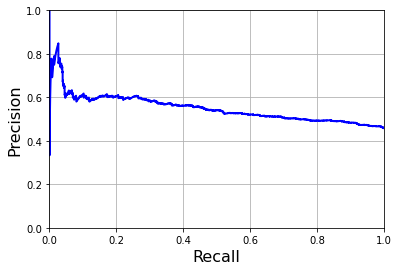

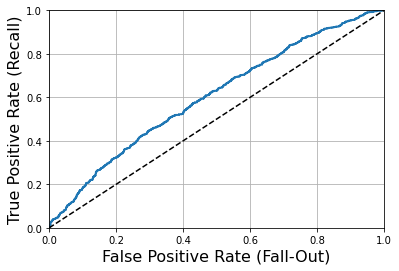

AUC: 0.6029654977598613


In [81]:
#linear svm
param_grid = [
    {'C': [0.0001,0.001,0.01,0.1,1,10,100,1000]},
    ]
est = LinearSVC(dual=False) 
n_iter = 8
resLinSVM = trainEvalFunc(param_grid, est, n_iter)

0.6331747212272074 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4}
0.6284982480029837 {'n_estimators': 500, 'min_samples_split': 7, 'min_samples_leaf': 1}
[[770 447]
 [487 534]]
Accuracy: 0.58266309204647
F1: 0.5334665334665335
Precision: 0.5443425076452599
Recall: 0.5230166503428012


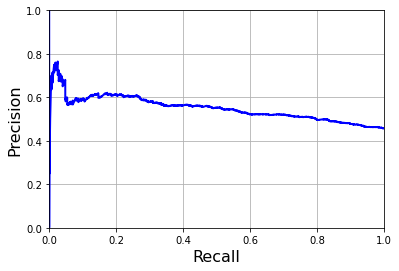

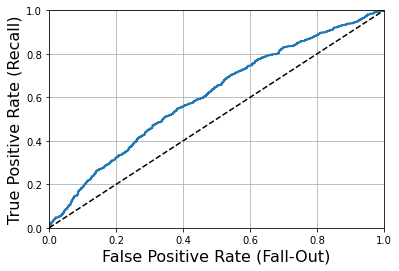

AUC: 0.607721014005796
tNeg 0.026557115368684717
tNeut 0.02514058422908697
tPos 0.025807457562549836
dNeg 0.026779879488879766
dNeut 0.025636286031555985
dPos 0.0256940497743893
artCnt 0.027580917754466402
close_open 0.0905819731750192
high_open 0.10512973464600801
low_open 0.10806672976108399
spy_close_open 0.07334548753339218
spy_high_open 0.07733575966023885
spy_low_open 0.0786998879523484
volPercent 0.09058812904612618
Mon 0.006731599574083968
Tues 0.007381639346433612
Wed 0.007006879435522516
Thurs 0.00775469224682684
Fri 0.006932900810036694
vixClose 0.07837730486803347
spy_vix 0.07887099173523321


In [82]:
#build random forest model
param_grid = [
    {'n_estimators': [50,100,300,500],'min_samples_split': [2,4,7,10], 
     'min_samples_leaf': [1,2,4,7,10,15,20]}
    ]
est = RandomForestClassifier(random_state=42)
n_iter = 2
resRF = trainEvalFunc(param_grid, est, n_iter, decFunc=False)

#feature importance with random forest
columns = ['tNeg','tNeut','tPos','dNeg','dNeut','dPos', 'artCnt', 'close_open','high_open','low_open','spy_close_open',
           'spy_high_open', 'spy_low_open','volPercent', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'vixClose','spy_vix']
for name, score in zip(columns, resRF[1].feature_importances_):
    print(name, score)

0.4854202624526224 {'n_estimators': 1000, 'learning_rate': 10}
0.6159158882422497 {'n_estimators': 10, 'learning_rate': 0.5}
[[716 501]
 [426 595]]
Accuracy: 0.5857908847184986
F1: 0.5621162021728862
Precision: 0.5428832116788321
Recall: 0.5827619980411362


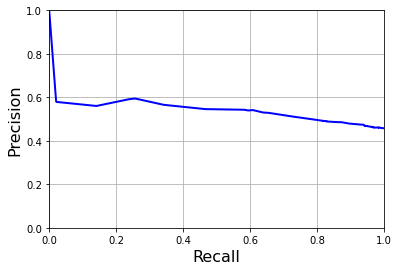

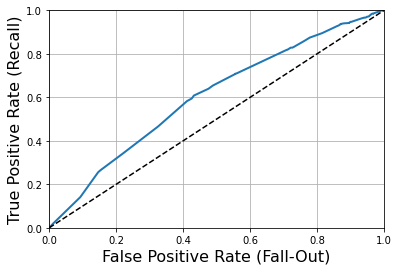

AUC: 0.6042213757598244


In [85]:
#Ada Boost
param_grid = [
    {'n_estimators': [5, 10, 100, 200, 500, 1000], 'learning_rate': [0.1, 0.5, 1, 5, 10]}
    ]
est = AdaBoostClassifier(algorithm="SAMME.R", random_state=42)
n_iter = 2
resADA = trainEvalFunc(param_grid, est, n_iter)

0.5557265872774949 {'subsample': 0.1, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.5}
0.6061403014244371 {'subsample': 0.1, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.1}
[[813 404]
 [551 470]]
Accuracy: 0.5732797140303842
F1: 0.49604221635883905
Precision: 0.5377574370709383
Recall: 0.4603330068560235


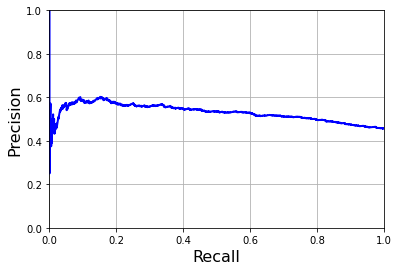

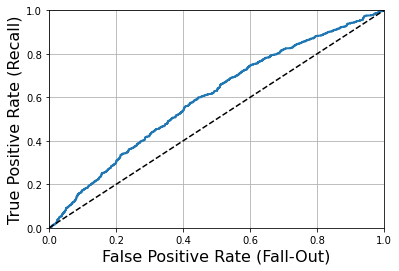

AUC: 0.596212487636382


In [86]:
#gradient boosting
param_grid = [
    {'n_estimators': [50, 200, 500, 1000], 'learning_rate': [0.001, 0.1, 0.2, 0.5, 1, 5],
     'subsample': [0.1, 0.5, 1], 'max_depth': [2, 3, 5], }
    ]
est = GradientBoostingClassifier(random_state=42)
n_iter = 40
resGB = trainEvalFunc(param_grid, est, n_iter)

In [ ]:
#Voting Classifier with best model from each grid search

logReg = LogisticRegression(random_state=42, max_iter=2000, C=0.7, penalty='l1', solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=50)
RF = RandomForestClassifier(random_state=42, min_samples_leaf=2, min_samples_split=10, n_estimators=500)
SVCmod = SVC(probability=True, kernel='poly', degre=3, C=0.5, ceof0=0.5)
ada = AdaBoostClassifier(algorithm="SAMME.R", random_state=42, learning_rate=0.1, n_estimators=200)
gbrt = GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1)

voting_clf = VotingClassifier(estimators=[('lr', logReg), ('knn', knn), ('RF', RF), ('ada', ada), 
                                          ('gbrt', gbrt), ('SVCmod', SVCmod)], voting='soft')
voting_clf.fit(preppedMagData[0], np.argmax(preppedMagData[1], axis=1))

evalModel(yTrue, voting_clf.predict(preppedMagData[6]))
plotPrecRecall(yTrue, voting_clf.decision_function(preppedMagData[6]))
plotRocCurve(yTrue, voting_clf.decision_function(preppedMagData[6]))

Epoch 1/100
736/736 [==============================] - 2s 2ms/step - loss: 1.0810 - accuracy: 0.4965 - val_loss: 0.9628 - val_accuracy: 0.4803
Epoch 2/100
736/736 [==============================] - 1s 1ms/step - loss: 1.0205 - accuracy: 0.5057 - val_loss: 0.9423 - val_accuracy: 0.4781
Epoch 3/100
736/736 [==============================] - 1s 1ms/step - loss: 1.0027 - accuracy: 0.5040 - val_loss: 0.9047 - val_accuracy: 0.4803
Epoch 4/100
736/736 [==============================] - 1s 1ms/step - loss: 0.9859 - accuracy: 0.4970 - val_loss: 0.8896 - val_accuracy: 0.4821
Epoch 5/100
736/736 [==============================] - 1s 1ms/step - loss: 0.9403 - accuracy: 0.5133 - val_loss: 0.8582 - val_accuracy: 0.4839
Epoch 6/100
736/736 [==============================] - 1s 1ms/step - loss: 0.9100 - accuracy: 0.5106 - val_loss: 0.8499 - val_accuracy: 0.4884
Epoch 7/100
736/736 [==============================] - 1s 1ms/step - loss: 0.9197 - accuracy: 0.5065 - val_loss: 0.8443 - val_accuracy: 0.4866

736/736 [==============================] - 1s 1ms/step - loss: 0.7030 - accuracy: 0.5600 - val_loss: 0.6793 - val_accuracy: 0.5666
Epoch 58/100
736/736 [==============================] - 1s 1ms/step - loss: 0.6910 - accuracy: 0.5681 - val_loss: 0.6816 - val_accuracy: 0.5585
Epoch 59/100
736/736 [==============================] - 1s 1ms/step - loss: 0.7010 - accuracy: 0.5533 - val_loss: 0.6795 - val_accuracy: 0.5702
Epoch 60/100
736/736 [==============================] - 1s 1ms/step - loss: 0.6972 - accuracy: 0.5693 - val_loss: 0.6782 - val_accuracy: 0.5710
Epoch 61/100
736/736 [==============================] - 1s 1ms/step - loss: 0.6939 - accuracy: 0.5662 - val_loss: 0.6777 - val_accuracy: 0.5706
Epoch 62/100
736/736 [==============================] - 1s 1ms/step - loss: 0.6984 - accuracy: 0.5584 - val_loss: 0.6776 - val_accuracy: 0.5715
Epoch 63/100
736/736 [==============================] - 1s 1ms/step - loss: 0.6954 - accuracy: 0.5589 - val_loss: 0.6776 - val_accuracy: 0.5715
Epoch

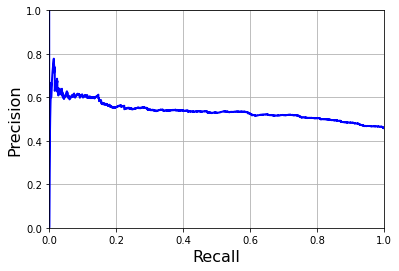

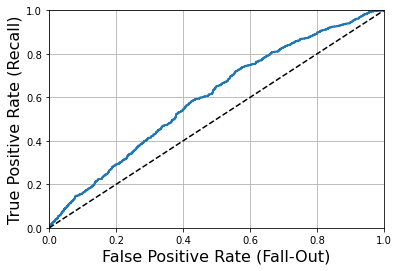

AUC: 0.599215971581183


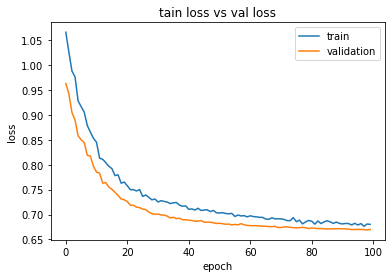

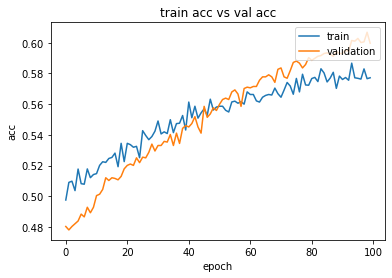

In [89]:
#build, compile, and train Dense network 
n_features = preppedMagData[0].shape[1]

np.random.seed(42)
tf.random.set_seed(42)

opt = Adam(1e-5)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[n_features]),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
history = model.fit(x=preppedMagData[0], y=preppedMagData[1], epochs=100, validation_data=(preppedMagData[2],preppedMagData[3]), shuffle=(True), batch_size = 16)
 
evalModel(np.argmax(preppedMagData[7], axis=1), np.argmax(model.predict(preppedMagData[6]),axis=1))
plotPrecRecall(np.argmax(preppedMagData[7], axis=1), model.predict(preppedMagData[6])[:,1])
plotRocCurve(np.argmax(preppedMagData[7], axis=1), model.predict(preppedMagData[6])[:,1])
plotLoss()
plotAcc()

In [90]:
#Monte Carlo Dropout
tf.random.set_seed(42)
np.random.seed(42)

y_probs = np.stack([model(preppedMagData[6], training=True) for sample in range(100)])
y_probAve = y_probs.mean(axis=0)
y_std = y_probs.std(axis=0)

y_pred = np.argmax(y_probAve, axis=1)
evalModel(np.argmax(preppedMagData[7], axis=1), y_pred)

[[658 559]
 [401 620]]
Accuracy: 0.5710455764075067
F1: 0.5636363636363637
Precision: 0.5258693808312129
Recall: 0.6072477962781586


In [ ]:
#adjusting threshold
thresh=.70
z = model.predict(preppedMagData[6])
z1 = pd.DataFrame(z)
zz = np.array(preppedMagData[7])
z1['T'] = zz[:,0]
z1['F'] = zz[:,1]
z2 = z1.loc[(z1[0]>thresh) | (z1[1]>thresh)]
w = np.argmax(np.array(z2[['T','F']]), axis = 1)
v = np.argmax(np.array(z2[[0,1]]), axis = 1)

print(confusion_matrix(w,v))
print("Accuracy:", accuracy_score(w,v))
print("F1:", f1_score(w,v))
print("Precision:", precision_score(w,v))
print("Recall:", recall_score(w,v))
print("AUC:", roc_auc_score(w,v))   

# SEQUENCE BASED MODELS

### PREPARE DATA FOR 3 DIM INPUT

In [138]:
#split dfs into 3Dim samples
def split_sequences(sequences, targets, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], targets[end_ix-1, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

n_steps = 5

In [139]:
#finish prep for RNN inputs and shuffle
def prepShuf(transformedTrainSet,amznTransformedTestSet,aaplTransformedTestSet,googTransformedTestSet,mag):
    if mag==True:
        x = 0
        y = 2
    else:
        x = 2
        y = 4
    amznX, amznY = split_sequences(transformedTrainSet[0][:3921], (array(transformedTrainSet[1][:3921]))[:,x:y], n_steps=n_steps)
    aaplX, aaplY = split_sequences(transformedTrainSet[0][3921:(3921*2)], (array(transformedTrainSet[1][3921:(3921*2)]))[:,x:y], n_steps=n_steps)
    googX, googY = split_sequences(transformedTrainSet[0][(3921*2):], (array(transformedTrainSet[1][(3921*2):]))[:,x:y], n_steps=n_steps)

    amznValX, amznValY = split_sequences(amznTransformedTestSet[0], (array(amznTransformedTestSet[1]))[:,x:y], n_steps=n_steps)
    aaplValX, aaplValY = split_sequences(aaplTransformedTestSet[0], (array(aaplTransformedTestSet[1]))[:,x:y], n_steps=n_steps)
    googValX, googValY = split_sequences(googTransformedTestSet[0], (array(googTransformedTestSet[1]))[:,x:y], n_steps=n_steps)
    
    splitCombTrain = vstack((amznX,aaplX,googX))
    splitCombTrainTargets = vstack((amznY,aaplY,googY))
    
    Xshuffled, Yshuffled = shuffle(splitCombTrain, splitCombTrainTargets, random_state=37)
    
    amznValShuffledX, amznValShuffledY = shuffle(amznValX, amznValY, random_state=41)
    aaplValShuffledX, aaplValShuffledY = shuffle(aaplValX, aaplValY, random_state=41)
    googValShuffledX, googValShuffledY = shuffle(googValX, googValY, random_state=41)
    
    return Xshuffled, Yshuffled, amznValShuffledX, amznValShuffledY, aaplValShuffledX, aaplValShuffledY, googValShuffledX, googValShuffledY

preppedMagData = prepShuf(transformedTrainSet,amznTransformedTestSet,aaplTransformedTestSet,googTransformedTestSet,mag=True)
preppedDirData = prepShuf(transformedTrainSet,amznTransformedTestSet,aaplTransformedTestSet,googTransformedTestSet,mag=False)


### BUILD AND EVALUATE SEQUENCE BASED MODELS

In [140]:
#define eval funcs for RNNs
def evalModel(model, DataSet=preppedMagData):
    u = model.predict(DataSet[6])
    v = np.argmax(u, axis = 1)
    w = np.argmax(np.array(DataSet[7]), axis=1)
    print(confusion_matrix(w,v))
    print("Accuracy:", accuracy_score(w,v))
    print("F1:", f1_score(w,v))
    print("Precision:", precision_score(w,v))
    print("Recall:", recall_score(w,v))
    print("AUC:", roc_auc_score(w,v))    
    
def plotRocCurve(model, DataSet=preppedMagData):
    v = model.predict(DataSet[6])[:,1]
    w = np.argmax(np.array(DataSet[7]), axis=1)
    fpr, tpr, thresholds = roc_curve(w, v)
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                  
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True) 
    plt.show()
    
def plotPrecRecall(model, DataSet=preppedMagData):
    v = model.predict(DataSet[6])[:,1]
    w = np.argmax(np.array(DataSet[7]), axis=1)
    precisions, recalls, thresholds = precision_recall_curve(w, v)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    plt.show()
    
def plotLoss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('tain loss vs val loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def plotAcc():
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('train acc vs val acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

Epoch 1/40
735/735 [==============================] - 7s 5ms/step - loss: 0.6964 - accuracy: 0.5016 - val_loss: 0.6912 - val_accuracy: 0.5313
Epoch 2/40
735/735 [==============================] - 3s 4ms/step - loss: 0.6975 - accuracy: 0.4938 - val_loss: 0.6908 - val_accuracy: 0.5309
Epoch 3/40
735/735 [==============================] - 3s 5ms/step - loss: 0.6970 - accuracy: 0.4965 - val_loss: 0.6904 - val_accuracy: 0.5354
Epoch 4/40
735/735 [==============================] - 3s 5ms/step - loss: 0.6957 - accuracy: 0.5095 - val_loss: 0.6901 - val_accuracy: 0.5380
Epoch 5/40
735/735 [==============================] - 3s 4ms/step - loss: 0.6938 - accuracy: 0.5147 - val_loss: 0.6898 - val_accuracy: 0.5421
Epoch 6/40
735/735 [==============================] - 3s 4ms/step - loss: 0.6928 - accuracy: 0.5167 - val_loss: 0.6895 - val_accuracy: 0.5398
Epoch 7/40
735/735 [==============================] - 3s 4ms/step - loss: 0.6938 - accuracy: 0.5175 - val_loss: 0.6892 - val_accuracy: 0.5403
Epoch 

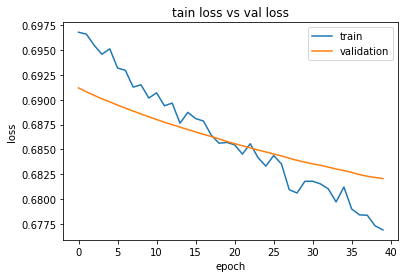

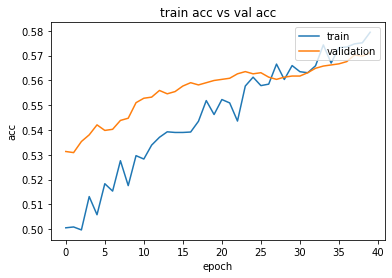

[[758 455]
 [497 524]]
Accuracy: 0.5738585496866607
F1: 0.5239999999999999
Precision: 0.5352400408580184
Recall: 0.5132223310479922
AUC: 0.5690596403797257


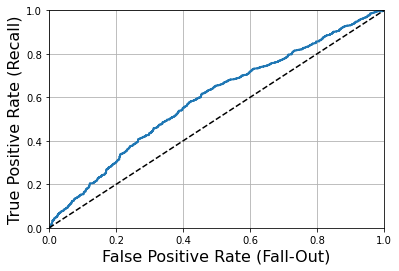

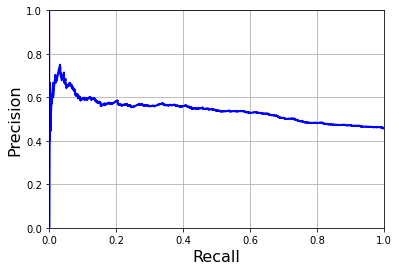

In [141]:
#build, compile, and train models
n_features = preppedMagData[0].shape[2]

np.random.seed(37)
tf.random.set_seed(37)

opt = Adam(2e-5)
opt = Adam(1e-5, clipvalue=1.0)

#build LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=[None, n_features]),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(2, activation='softmax')
])

#compile and fit model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
history = model.fit(x=preppedMagData[0], y=preppedMagData[1], epochs=40, validation_data=(preppedMagData[2],preppedMagData[3]), shuffle=(True), batch_size = 16)

plotLoss()
plotAcc()
evalModel(model)
plotRocCurve(model)
plotPrecRecall(model)


Epoch 1/40
735/735 [==============================] - 8s 5ms/step - loss: 0.7084 - accuracy: 0.5197 - val_loss: 0.7017 - val_accuracy: 0.5116
Epoch 2/40
735/735 [==============================] - 3s 5ms/step - loss: 0.7010 - accuracy: 0.5381 - val_loss: 0.7005 - val_accuracy: 0.5107
Epoch 3/40
735/735 [==============================] - 3s 5ms/step - loss: 0.7002 - accuracy: 0.5376 - val_loss: 0.6993 - val_accuracy: 0.5121
Epoch 4/40
735/735 [==============================] - 3s 5ms/step - loss: 0.6993 - accuracy: 0.5326 - val_loss: 0.6982 - val_accuracy: 0.5116
Epoch 5/40
735/735 [==============================] - 4s 5ms/step - loss: 0.6994 - accuracy: 0.5381 - val_loss: 0.6971 - val_accuracy: 0.5148
Epoch 6/40
735/735 [==============================] - 4s 5ms/step - loss: 0.6988 - accuracy: 0.5354 - val_loss: 0.6961 - val_accuracy: 0.5184
Epoch 7/40
735/735 [==============================] - 4s 5ms/step - loss: 0.6915 - accuracy: 0.5452 - val_loss: 0.6950 - val_accuracy: 0.5206
Epoch 

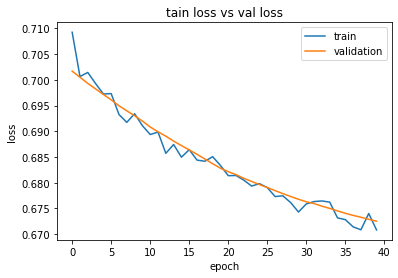

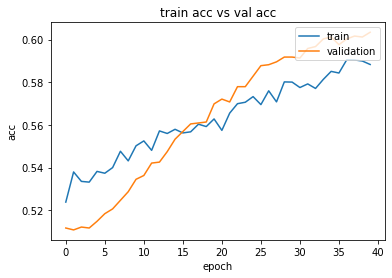

[[829 384]
 [517 504]]
Accuracy: 0.5966875559534467
F1: 0.5280251440544788
Precision: 0.5675675675675675
Recall: 0.49363369245837413
AUC: 0.5885316030305061


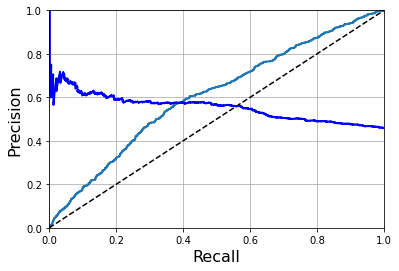

In [95]:
#build GRU model
np.random.seed(37)
tf.random.set_seed(37)

model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(10, return_sequences=True, input_shape=[None, n_features]),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GRU(10),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(2, activation='softmax')
])

#compile and fit model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
history = model.fit(x=preppedMagData[0], y=preppedMagData[1], epochs=40, validation_data=(preppedMagData[2],preppedMagData[3]), shuffle=(True), batch_size = 16)

plotLoss()
plotAcc()
evalModel(model)
plotRocCurve(model)
plotPrecRecall(model)

In [ ]:
#build Conv1D model
np.random.seed(37)
tf.random.set_seed(37)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=20, kernel_size=2, strides=1, padding="valid", input_shape=[n_steps, n_features]),
    #tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(20),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(2, activation='softmax')
])

#compile and fit model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
history = model.fit(x=preppedMagData[0], y=preppedMagData[1], epochs=20, validation_data=(preppedMagData[2],preppedMagData[3]), shuffle=(True), batch_size = 16)

plotLoss()
plotAcc()
evalModel(model)
plotRocCurve(model)
plotPrecRecall(model)


In [ ]:
#build WaveNet model
np.random.seed(37)
tf.random.set_seed(37)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[n_steps, n_features]))
for rate in (1, 2, 4, 8) * 2:
    model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(tf.keras.layers.GRU(20, return_sequences=True))
model.add(tf.keras.layers.GRU(20))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

#compile and fit model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
history = model.fit(x=preppedMagData[0], y=preppedMagData[1], epochs=40, validation_data=(preppedMagData[2],preppedMagData[3]), shuffle=(True), batch_size = 16)

plotLoss()
plotAcc()
evalModel(model)
plotRocCurve(model)
plotPrecRecall(model)

In [ ]:
#Monte Carlo Dropout
tf.random.set_seed(42)
np.random.seed(42)

y_probs = np.stack([model(preppedMagData[6], training=True) for sample in range(100)])
y_probAve = y_probs.mean(axis=0)
y_std = y_probs.std(axis=0)

y_pred = np.argmax(y_probAve, axis=1)
evalModel(np.argmax(preppedMagData[7], axis=1), y_pred)